https://medium.com/swlh/image-processing-with-python-histogram-manipulation-on-digital-images-d4fb426d3513
img : https://missslow.com/stonehenge/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage import img_as_ubyte
from skimage.color import rgb2gray
# from skimage.exposure import  cumulative_distribution
from scipy.stats import cauchy, logistic

In [2]:
# https://github.com/scikit-image/scikit-image/blob/main/skimage/exposure/exposure.py

def _get_numpy_hist_range(image, source_range):
    if source_range == 'image':
        hist_range = None
    elif source_range == 'dtype':
        hist_range = dtype_limits(image, clip_negative=False)
    else:
        ValueError('Wrong value for the `source_range` argument')
    return hist_range


def histogram(image, nbins=256, source_range='image', normalize=False, *,channel_axis=None):
   
    sh = image.shape

    if channel_axis is not None:
        channels = sh[-1]
        hist = []

        # compute bins based on the raveled array
        if np.issubdtype(image.dtype, np.integer):
            # here bins corresponds to the bin centers
            bins = _bincount_histogram_centers(image, source_range)
        else:
            # determine the bin edges for np.histogram
            hist_range = _get_numpy_hist_range(image, source_range)
            bins = _get_bin_edges(image, nbins, hist_range)

        for chan in range(channels):
            h, bc = _histogram(image[..., chan], bins, source_range, normalize)
            hist.append(h)
        # Convert to numpy arrays
        bin_centers = np.asarray(bc)
        hist = np.stack(hist, axis=0)
    else:
        hist, bin_centers = _histogram(image, nbins, source_range, normalize)

    return hist, bin_centers


def _histogram(image, bins, source_range, normalize):

    image = image.flatten()
    # For integer types, histogramming with bincount is more efficient.
    if np.issubdtype(image.dtype, np.integer):
        bin_centers = bins if isinstance(bins, np.ndarray) else None
        hist, bin_centers = _bincount_histogram(image, source_range, bin_centers)
    else:
        hist_range = _get_numpy_hist_range(image, source_range)
        hist, bin_edges = np.histogram(image, bins=bins, range=hist_range)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.

    if normalize:
        hist = hist / np.sum(hist)
    return hist, bin_centers


In [41]:
# https://github.com/scikit-image/scikit-image/blob/main/skimage/exposure/exposure.py

def cumulative_distribution(image, nbins=256):
 
    hist, bin_centers = histogram(image, nbins)
    img_cdf = hist.cumsum()
#     print(img_cdf,hist)
    img_cdf = img_cdf / float(img_cdf[-1])
    return img_cdf, bin_centers

def _bincount_histogram(image, source_range, bin_centers=None):

    if bin_centers is None:
        bin_centers = _bincount_histogram_centers(image, source_range)
    image_min, image_max = bin_centers[0], bin_centers[-1]
    image, offset = _offset_array(image, image_min, image_max)
    hist = np.bincount(image.ravel(), minlength=image_max - image_min + 1)
    if source_range == 'image':
        idx = max(image_min, 0)
        hist = hist[idx:]
    return hist, bin_centers

def _bincount_histogram_centers(image, source_range):
    """Compute bin centers for bincount-based histogram."""
    if source_range not in ['image', 'dtype']:
        raise ValueError(
            f'Incorrect value for `source_range` argument: {source_range}'
        )
    if source_range == 'image':
        image_min = int(image.min().astype(np.int64))
        image_max = int(image.max().astype(np.int64))
    elif source_range == 'dtype':
        image_min, image_max = dtype_limits(image, clip_negative=False)
    bin_centers = np.arange(image_min, image_max + 1)
    return bin_centers

def _offset_array(arr, low_boundary, high_boundary):
    """Offset the array to get the lowest value at 0 if negative."""
    if low_boundary < 0:
        offset = low_boundary
        dyn_range = high_boundary - low_boundary
        # get smallest dtype that can hold both minimum and offset maximum
        offset_dtype = np.promote_types(np.min_scalar_type(dyn_range),
                                        np.min_scalar_type(low_boundary))
        if arr.dtype != offset_dtype:
            # prevent overflow errors when offsetting
            arr = arr.astype(offset_dtype)
        arr = arr - offset
    else:
        offset = 0
    return arr, offset

Text(0.5, 1.0, 'Manila Cathedral')

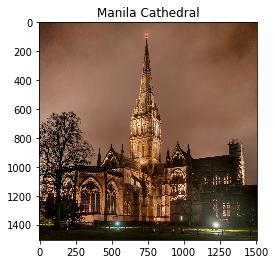

In [42]:
cathedral = imread('Salisbury-cathedral.jpg')
plt.imshow(cathedral)
plt.title('Manila Cathedral')

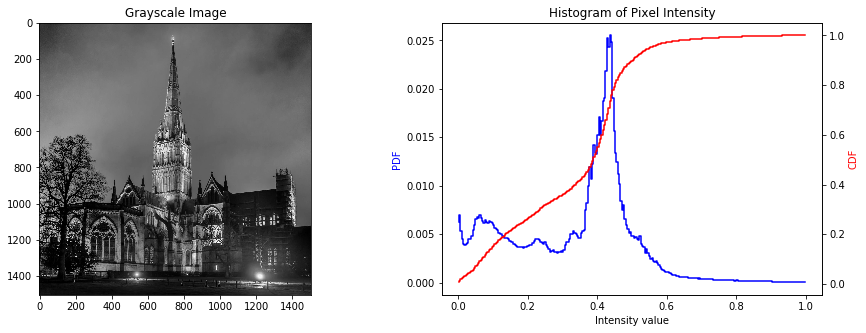

In [43]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
cathedral_gray = rgb2gray(cathedral)
ax[0].imshow(cathedral_gray, cmap='gray')
ax[0].set_title('Grayscale Image')
ax1 = ax[1]
ax2 = ax1.twinx()
freq_h, bins_h = histogram(cathedral_gray)
freq_c, bins_c = cumulative_distribution(cathedral_gray)
ax1.step(bins_h, freq_h*1.0/freq_h.sum(), c='b', label='PDF')
ax2.step(bins_c, freq_c, c='r',  label='CDF')
ax1.set_ylabel('PDF', color='b')
ax2.set_ylabel('CDF', color='r')
ax[1].set_xlabel('Intensity value')
ax[1].set_title('Histogram of Pixel Intensity');

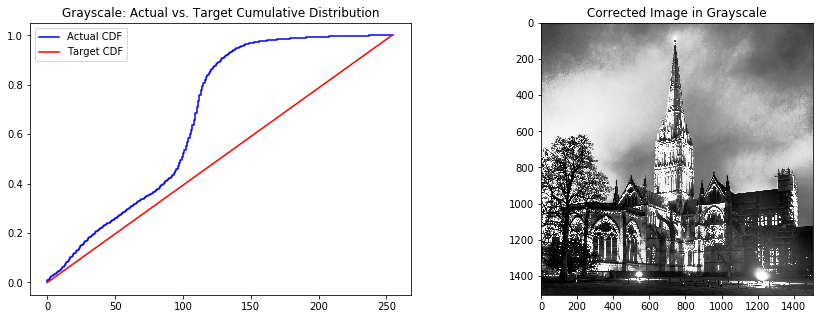

In [44]:
image_intensity = img_as_ubyte(cathedral_gray)
freq, bins = cumulative_distribution(image_intensity)
target_bins = np.arange(255)
target_freq = np.linspace(0, 1, len(target_bins))
new_vals = np.interp(freq, target_freq, target_bins)
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].step(bins, freq, c='b', label='Actual CDF')
ax[0].plot(target_bins, target_freq, c='r', label='Target CDF')
ax[0].legend()
ax[0].set_title('Grayscale: Actual vs. ''Target Cumulative Distribution')
ax[1].imshow(new_vals[image_intensity].astype(np.uint8), cmap='gray')
ax[1].set_title('Corrected Image in Grayscale');

In [51]:
def show_linear_cdf(image, channel, name, ax):
    image_intensity = img_as_ubyte(image[:,:,channel])
    freq, bins = cumulative_distribution(image_intensity)
    target_bins = np.arange(255)
    target_freq = np.linspace(0, 1, len(target_bins))
    ax.step(bins, freq, c='b', label='Actual CDF')
    ax.plot(target_bins, target_freq, c='r', label='Target CDF')
    ax.legend()
    ax.set_title('{} Channel: Actual vs. '
                 'Target Cumulative Distribution'.format(name))
    
def linear_distribution(image, channel):
    image_intensity = image[:,:,channel]
    freq, bins = cumulative_distribution(image_intensity)
    target_bins = np.arange(255)
    target_freq = np.linspace(0, 1, len(target_bins))
    new_vals = np.interp(freq, target_freq, target_bins)
    print(new_vals)
    return new_vals[image_intensity].astype(np.uint8)


[  0.83780593   1.58893069   2.16411732   2.70884236   3.26308665
   3.73434549   4.34055368   4.92548355   5.51041341   6.08448014
   6.8014476    7.52457457   8.22272751   9.04978228   9.97124561
  11.01645917  12.18844674  13.46872977  14.76189179  16.07879593
  17.40745914  18.70140509  20.02155698  21.29848027  22.57305175
  23.74470335  24.953648    26.14624195  27.3171096   28.48148178
  29.61696022  30.77965253  31.9795259   33.17447166  34.38498419
  35.62147867  36.8357989   38.03085665  39.21370737  40.33888263
  41.47570497  42.58262567  43.63825442  44.6681252   45.66103889
  46.6246109   47.58650304  48.51300597  49.42259823  50.30520062
  51.19004284  52.05819837  52.94360054  53.77726279  54.62246014
  55.48479213  56.33200531  57.20486447  58.07145213  58.90141867
  59.7290334   60.5773665   61.41730025  62.23147604  63.00768683
  63.76015548  64.50064108  65.22052031  65.93659184  66.62746535
  67.31811488  67.96307201  68.57913543  69.18870335  69.76411397
  70.33426

Text(0.5, 1.0, 'Corrected Image in Blue Channel')

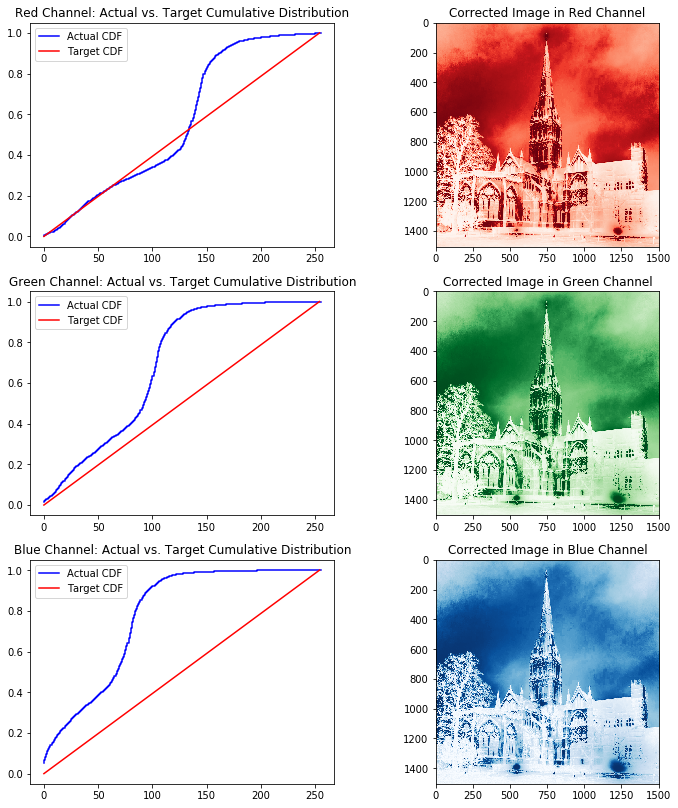

In [52]:
fig, ax = plt.subplots(3,2, figsize=(12,14))
red_channel = linear_distribution(cathedral, 0)
green_channel = linear_distribution(cathedral, 1)
blue_channel = linear_distribution(cathedral, 2)

show_linear_cdf(cathedral, 0, 'Red', ax[0,0])
ax[0,1].imshow(red_channel, cmap='Reds')
ax[0,1].set_title('Corrected Image in Red Channel')
show_linear_cdf(cathedral, 1, 'Green', ax[1,0])
ax[1,1].imshow(green_channel, cmap='Greens')
ax[1,1].set_title('Corrected Image in Green Channel')
show_linear_cdf(cathedral, 2, 'Blue', ax[2,0])
ax[2,1].imshow(blue_channel, cmap='Blues')
ax[2,1].set_title('Corrected Image in Blue Channel')

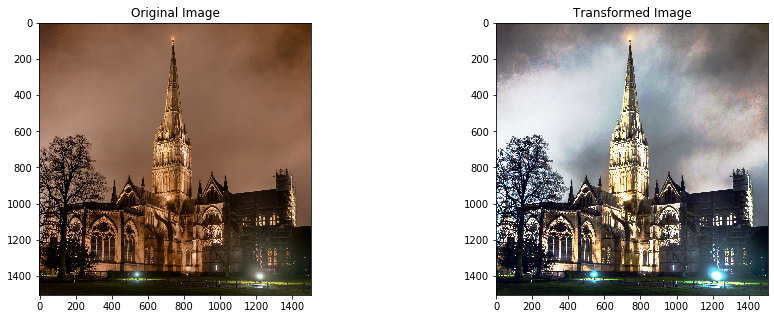

In [25]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(cathedral)
ax[0].set_title('Original Image')
ax[1].imshow(np.dstack([red_channel, green_channel, blue_channel]));
ax[1].set_title('Transformed Image');

In [10]:
# plt.imshow(np.dstack([red_channel, green_channel, blue_channel]))
# plt.savefig('cathedral.jpg')